<a href="https://colab.research.google.com/github/Aswin-Cheerngodan/Generative-Models/blob/main/mnist_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Flatten, Input
import matplotlib.pyplot as plt

In [2]:
def generator_model():
    model = Sequential([
        Input(shape=(100,)),
        Dense(256, use_bias=False),
        BatchNormalization(),
        LeakyReLU(),

        Dense(512),
        BatchNormalization(),
        LeakyReLU(),

        Dense(28*28, activation='tanh'),
        Reshape((28,28,1))
    ])

    return model


def discriminator_model():
    model = Sequential([
        Input(shape=(28,28,1)),
        Flatten(),
        Dense(512),
        LeakyReLU(),

        Dense(256),
        LeakyReLU(),
        Dense(1, activation='sigmoid')
    ])

    return model

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    total_loss = real_loss + fake_loss
    return total_loss

def generate_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = generator_model()
discriminator = discriminator_model()

cross_entropy = tf.keras.losses.BinaryCrossentropy()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generate_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_dis = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_dis, discriminator.trainable_variables))


def train(dataset, epochs):
    for epoch in range(epochs):
        print(f"epoch: {epoch}")
        for image_batch in dataset:
            train_step(image_batch)



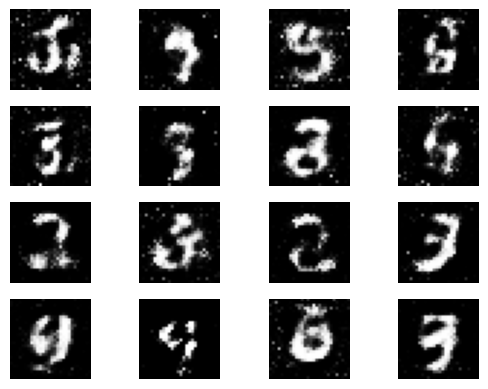

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images/127.5 - 1
train_images = tf.expand_dims(train_images, axis=-1)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(256)

epochs = 50
batch_size = 128

for epoch in range(epochs):
    for image_batch in train_dataset:
        train_step(image_batch)

    noise = tf.random.normal([16,100])
    generated_img = generator(noise, training=False)

    for i in range(generated_img.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(generated_img[i,:,:,0], cmap='gray')
        plt.axis('off')

    plt.show